# 0.0. IMPORTS

In [121]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb


#from pycorrcat import pycorrcat

from boruta                import BorutaPy
from lightgbm              import LGBMRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.linear_model  import LinearRegression, Lasso

from sklearn               import model_selection   as ms
from sklearn               import ensemble          as en

## 0.1. Aux Functions

In [66]:
def settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    sns.set()


def ml_error( model_name, ytest, yhat ):
    mae = mean_absolute_error( ytest, yhat )
    mape = mean_absolute_percentage_error( ytest, yhat )
    rmse = np.sqrt( mean_squared_error( ytest, yhat ) )
    
    return pd.DataFrame( {'Model name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

def analise_bivariada(df,column):
    aux1=df[[column,'preco']].groupby(column).mean().reset_index()
    aux2=df[[column,'preco']].groupby(column).median().reset_index()
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    sns.barplot(x=column,y='preco',data=aux1)
    plt.subplot(2,1,2)
    sns.barplot(x=column,y='preco',data=aux2)


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE' : mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def runCrossValidation(model, x_train, x_val_ml, y_train, y_val, n_splits, n_repeats, verbose=False):
    '''
    Make cross validation with parameters of total ranking (k)
    return a dataframe with metrics of precision and recall at k
    '''
    # local import
    from sklearn.model_selection import RepeatedStratifiedKFold

    
    if verbose:
        # the lenght_msg is to print only once a specific message
        length_msg = True
        i = 1
    
    # the seed usage provides repeatability 
    np.random.seed(1231234)
    
    # it is necessary to join the train and validation datasets
    x = pd.concat([x_train, x_val_ml])
    y = pd.concat([y_train, y_val])
    
    
    # definition of the cross-validation strategy
    # - the "n_splits" parameter is the number of folds (k)
    # - the "n_repeats" parameter is the number of times cross-validator needs to 
    #   be repeated
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats )
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for train_index, prim_val_index in cv.split(x, y):      
        x_training, x_prim_val = x.iloc[train_index], x.iloc[prim_val_index]
        y_training, y_prim_val = y.iloc[train_index], y.iloc[prim_val_index]
        
        if (verbose == True) and (length_msg == True):
            print(f'training_lenght:{x_training.shape[0]}\nvalidation_lenght:{x_prim_val.shape[0]}\n\n')
            length_msg = False
        
        if verbose:
            print(f'Iteration number:{i}')
            i += 1

        # fit and predict_proba
        model.fit(x_training, y_training)
        yhat = model.predict(x_prim_val)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    return pd.DataFrame({'Model name': model_name,
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 0.2. Reading Data

In [10]:
df_raw=pd.read_csv('work/treino.csv')
df_test=pd.read_csv('work/teste.csv')

# 1.0. DESCRIÇÃO DOS DADOS

In [11]:
df1=df_raw.copy()
df1.columns=['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco']

## 1.1. Dimensão dos Dados

In [12]:
df1.shape

(39446, 29)

## 1.2. NA Check

In [13]:
df1.isna().sum()

id                                                                0
num_fotos                                                       237
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

### 1.2.1. Fillout NA

In [14]:
df1['num_fotos']=df1['num_fotos'].fillna(0)
df1['attr_veiculo_aceita_troca'] = df1['attr_veiculo_aceita_troca'].apply(lambda x: 1 if x=='Aceita troca' else 0)
df1['attr_veiculo_unico_dono'] = df1['attr_veiculo_unico_dono'].apply(lambda x: 1 if x=='Único dono' else 0)
df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'] = df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].apply(lambda x: 1 if x=='Todas as revisões feitas pela concessionária' else 0)
df1['attr_veiculo_ipva_pago'] = df1['attr_veiculo_ipva_pago'].apply(lambda x: 1 if x=='IPVA pago' else 0)
df1['attr_veiculo_licenciado'] = df1['attr_veiculo_licenciado'].apply(lambda x: 1 if x=='Licenciado' else 0)
df1['attr_veiculo_garantia_de_fabrica'] = df1['attr_veiculo_garantia_de_fabrica'].apply(lambda x: 1 if x=='Garantia de fábrica' else 0)
df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'] = df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].apply(lambda x: 1 if x=='Todas as revisões feitas pela agenda do carro' else 0)

## 1.3. Tipos dos Dados

In [15]:
df1.dtypes

id                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

### 1.3.1. Change data types

In [16]:
df1['num_fotos']=df1['num_fotos'].astype('int64')
df1['ano_modelo']=df1['ano_modelo'].astype('int64')
df1['odometro']=df1['odometro'].astype('int64')
df1['attr_veiculo_aceita_troca']=df1['attr_veiculo_aceita_troca'].astype('int64')
df1['attr_veiculo_unico_dono']=df1['attr_veiculo_unico_dono'].astype('int64')
df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria']=df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].astype('int64')
df1['attr_veiculo_ipva_pago']=df1['attr_veiculo_ipva_pago'].astype('int64')
df1['attr_veiculo_licenciado']=df1['attr_veiculo_licenciado'].astype('int64')
df1['attr_veiculo_garantia_de_fabrica']=df1['attr_veiculo_garantia_de_fabrica'].astype('int64')
df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro']=df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].astype('int64')
df1['attr_veiculo_alienado']=df1['attr_veiculo_alienado'].astype(str)

## 1.4. Estatística Descritiva

In [17]:
num_attr=df1.select_dtypes(include=['int64','float64'])
cat_attr=df1.select_dtypes(exclude=['int64','float64'])

### 1.4.1 Atributos Numéricos

In [18]:
# Central Tendency - mean, median
ct1=pd.DataFrame(num_attr.apply(np.mean)).T
ct2=pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attr.apply(np.std)).T
d2=pd.DataFrame(num_attr.apply(min)).T
d3=pd.DataFrame(num_attr.apply(max)).T
d4=pd.DataFrame(num_attr.apply(lambda x: x.max()-x.min())).T
d5=pd.DataFrame(num_attr.apply(lambda x: x.skew())).T
d6=pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T

# Concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.000000,2.100000e+01,2.100000e+01,10.261801,8.000000,3.561070,0.831612,-0.397392
1,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
2,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.807154,2018.000000,2.675300,-0.498274,-0.534887
3,odometro,100.000000,3.900650e+05,3.899650e+05,58382.243371,57244.500000,32542.380554,0.606748,1.251382
4,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
5,attr_veiculo_aceita_troca,0.000000,1.000000e+00,1.000000e+00,0.741013,1.000000,0.438078,-1.100361,-0.789246
6,attr_veiculo_unico_dono,0.000000,1.000000e+00,1.000000e+00,0.352330,0.000000,0.477696,0.618284,-1.617807
7,attr_veiculo_todas_as_revisoes_feitas_pela_con...,0.000000,1.000000e+00,1.000000e+00,0.310272,0.000000,0.462605,0.820289,-1.327193
8,attr_veiculo_ipva_pago,0.000000,1.000000e+00,1.000000e+00,0.664782,1.000000,0.472067,-0.698158,-1.512652
9,attr_veiculo_licenciado,0.000000,1.000000e+00,1.000000e+00,0.538711,1.000000,0.498499,-0.155317,-1.975977


### 1.4.2. Atributos Categóricos

In [19]:
cat_attr.apply(lambda x: x.unique().shape[0])

id                       39446
marca                       41
modelo                     473
versao                    2058
cambio                       7
tipo                         8
blindado                     2
cor                          8
tipo_vendedor                2
cidade_vendedor            648
estado_vendedor             25
tipo_anuncio                 4
entrega_delivery             2
troca                        2
elegivel_revisao             1
attr_veiculo_alienado        1
dtype: int64

<AxesSubplot:xlabel='tipo_vendedor', ylabel='preco'>

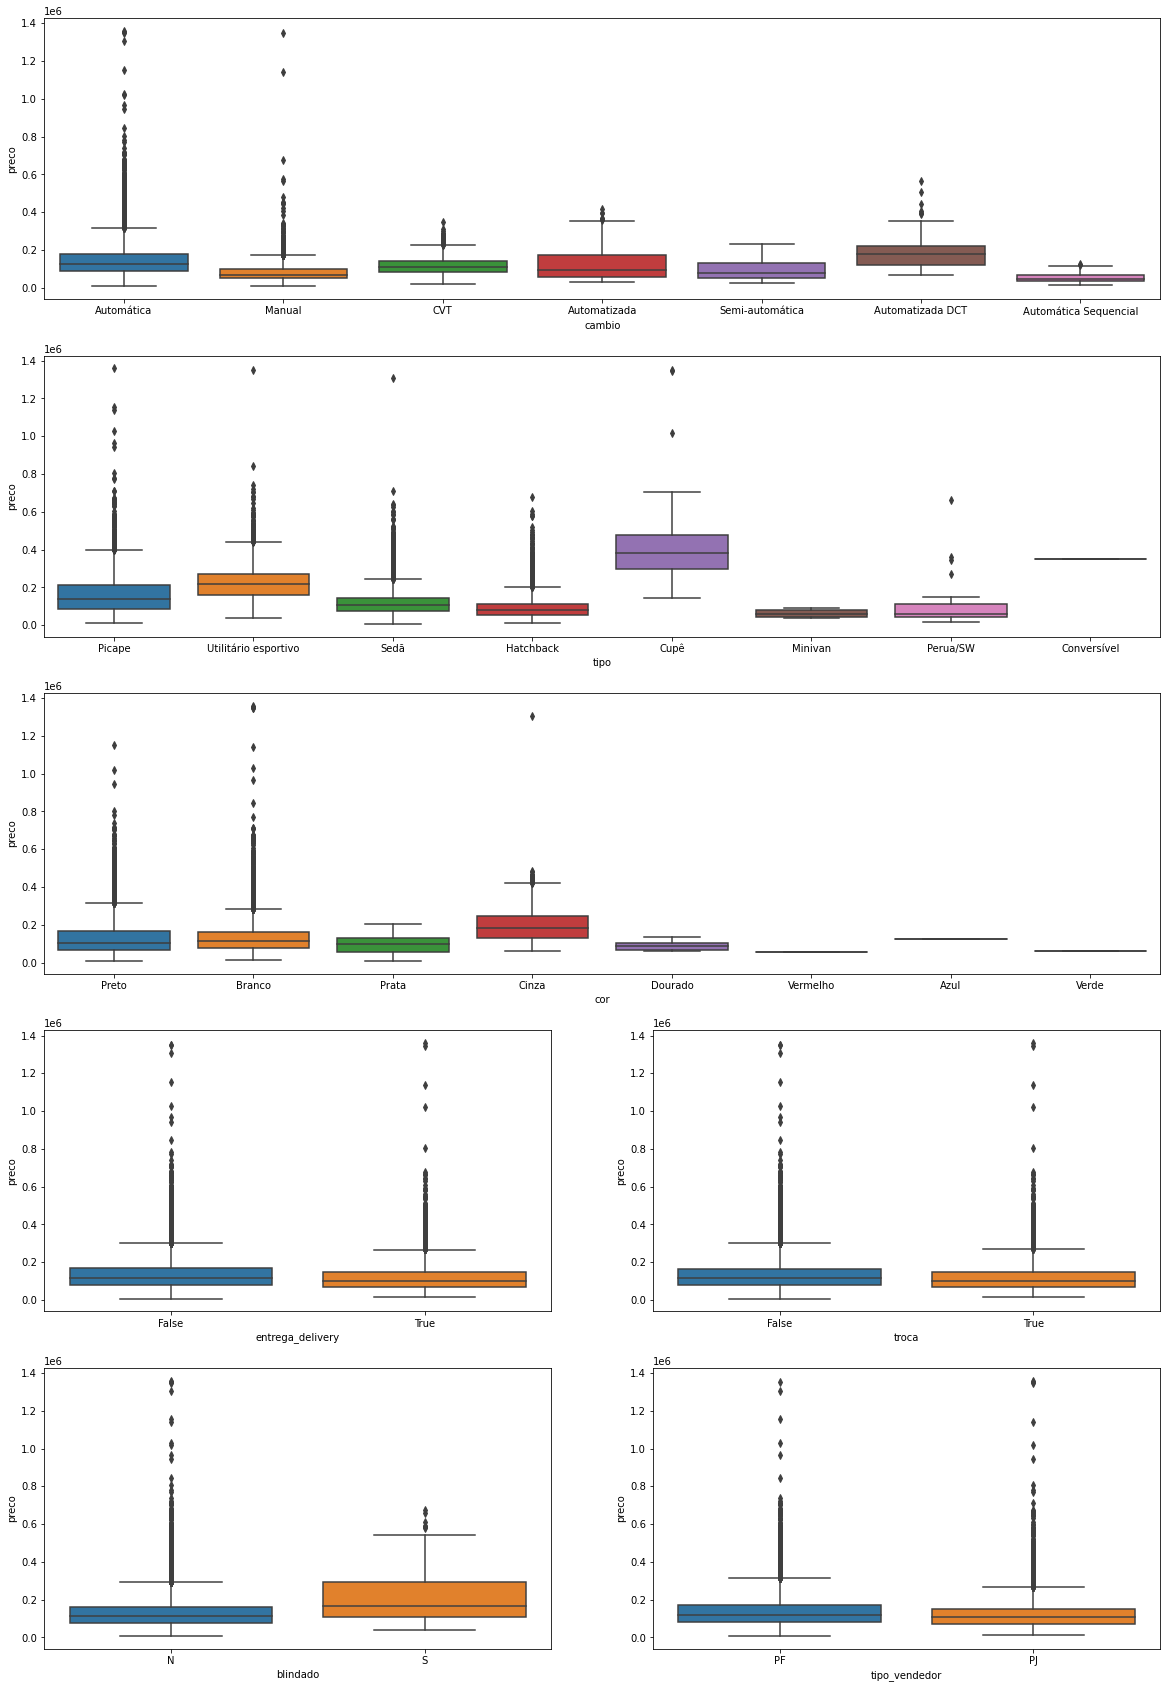

In [20]:
plt.figure(figsize=(20,30))
plt.subplot(5,2,(1,2))
sns.boxplot(x='cambio',y='preco',data=df1)
plt.subplot(5,2,(3,4))
sns.boxplot(x='tipo',y='preco',data=df1)
plt.subplot(5,2,(5,6))
sns.boxplot(x='cor',y='preco',data=df1)
plt.subplot(5,2,7)
sns.boxplot(x='entrega_delivery',y='preco',data=df1)
plt.subplot(5,2,8)
sns.boxplot(x='troca',y='preco',data=df1)
plt.subplot(5,2,9)
sns.boxplot(x='blindado',y='preco',data=df1)
plt.subplot(5,2,10)
sns.boxplot(x='tipo_vendedor',y='preco',data=df1)

# 2.0. FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

## 2.2. Criação de Hipóteses

## 2.3. Lista de Hipóteses

## 2.4. Feature Engineering

In [22]:
## ano de fabricacao one hot
#bin1 = [1985, 2000]
#bin2 = [2000, 2005]
#bin3 = [2005, 2010]
#bin4 = [2010, 2015]
#bin5 = [2015, 2020]
#bin6 = [2020, 2025]
#bins = [bin1, bin2, bin3, bin4, bin5, bin6]
#
#year_bins = []
#
#for i in range(df2.shape[0]):
#    tmp = [0 for i in range(len(bins))]
#    ye = df2['ano_de_fabricacao'][i]
#    for j in range(len(bins)):
#        if ye >= bins[j][0] and ye < bins[j][1]:
#            tmp[j] = 1
#    year_bins.append(tmp)
#year_bins = np.asarray(year_bins)
#new_df = pd.DataFrame(year_bins, columns=['Year_Bin'+str(i+1) for i in range(len(bins))])
#df2 = pd.concat( [df2, new_df], axis=1 )

# cbin1 = [7000, 20000]
# cbin2 = [20000, 40000]
# cbin3 = [40000, 80000]
# cbin4 = [80000, 100000]
# cbin5 = [100000, 200000]
# cbin6 = [200000, 500000]
# cbin7 = [500000, 1000000]
# cbins = [bin1, bin2, bin3, bin4, bin5, bin7]

# cyear_bins = []

# for i in range(df2.shape[0]):
#     tmp = [0 for i in range(len(cbins))]
#     ye = df2['ano_de_fabricacao'][i]
#     for j in range(len(cbins)):
#         if ye >= cbins[j][0] and ye < cbins[j][1]:
#             tmp[j] = 1
#     year_bins.append(tmp)
# year_bins = np.asarray(cyear_bins)
# new_df = pd.DataFrame(cyear_bins, columns=['Year_Bin'+str(i+1) for i in range(len(cbins))])
# df2 = pd.concat( [df2, new_df], axis=1 )
# df2 = df2.drop(columns=['ano_de_fabricacao'])

# =======================================================================

# ano de fabricação
df2['ano_de_fabricacao_2011']=df2['ano_de_fabricacao'].apply(lambda x: 1 if x>2010 else 0)
# ano_modelo
df2['ano_modelo_2011']=df2['ano_de_fabricacao'].apply(lambda x: 1 if x>2010 else 0)
# kilometragem 100 - 400000
df2['km']=df2['odometro'].apply(lambda x: '0_40000' if x<=40000 else
                                            '40000_80000'if x<=80000 else
                                            '80000_120000' if x<=120000  else
                                            '120000_160000' if x<=160000  else
                                            '160000_200000' if x<=200000  else
                                            '200000_240000' if x<=240000  else
                                            '240000_280000' if x<=280000  else
                                            '280000_320000' if x<=320000  else
                                            '320000_360000' if x<=360000  else
                                            '360000_400000')
# motor
df2['motor_3_chr']=df2['versao'].apply(lambda x: x[0:3])
df2['motor_num']=df2['motor_3_chr'].apply(lambda x: x[0:1].isnumeric())
df2['motor_ponto']=df2['motor_3_chr'].apply(lambda x: x[1:2]=='.')
df2['motor']=df2[['motor_num','motor_ponto','motor_3_chr']].apply(lambda x: x['motor_3_chr'] if (x['motor_num']==True)&(x['motor_ponto']==True) else 0,axis=1)
df2['motor']=df2['motor'].astype('float64')


# 3.0. FILTRAGEM DE VARIÁVEIS

In [23]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [24]:
# substituindo ano de fabricacao caso a diferença para o ano modelo seja superior a 1 ano
#df3['dif_ano'] = df3.apply(lambda x: x['ano_modelo'] - x['ano_de_fabricacao'], axis=1)
#df3[df3['dif_ano'] > 1].count()
#
#df3['ano_de_fabricacao'] = df3.apply(lambda x: (x['ano_modelo']-1) if x['dif_ano'] > 1 else x['ano_de_fabricacao'], axis=1)

## 3.2. Seleção das Colunas

In [25]:
df3 = df3.drop( columns=['elegivel_revisao','attr_veiculo_alienado', 'motor_3_chr', 'motor_num', 'motor_ponto','versao'])

# 4.0. EDA

In [26]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


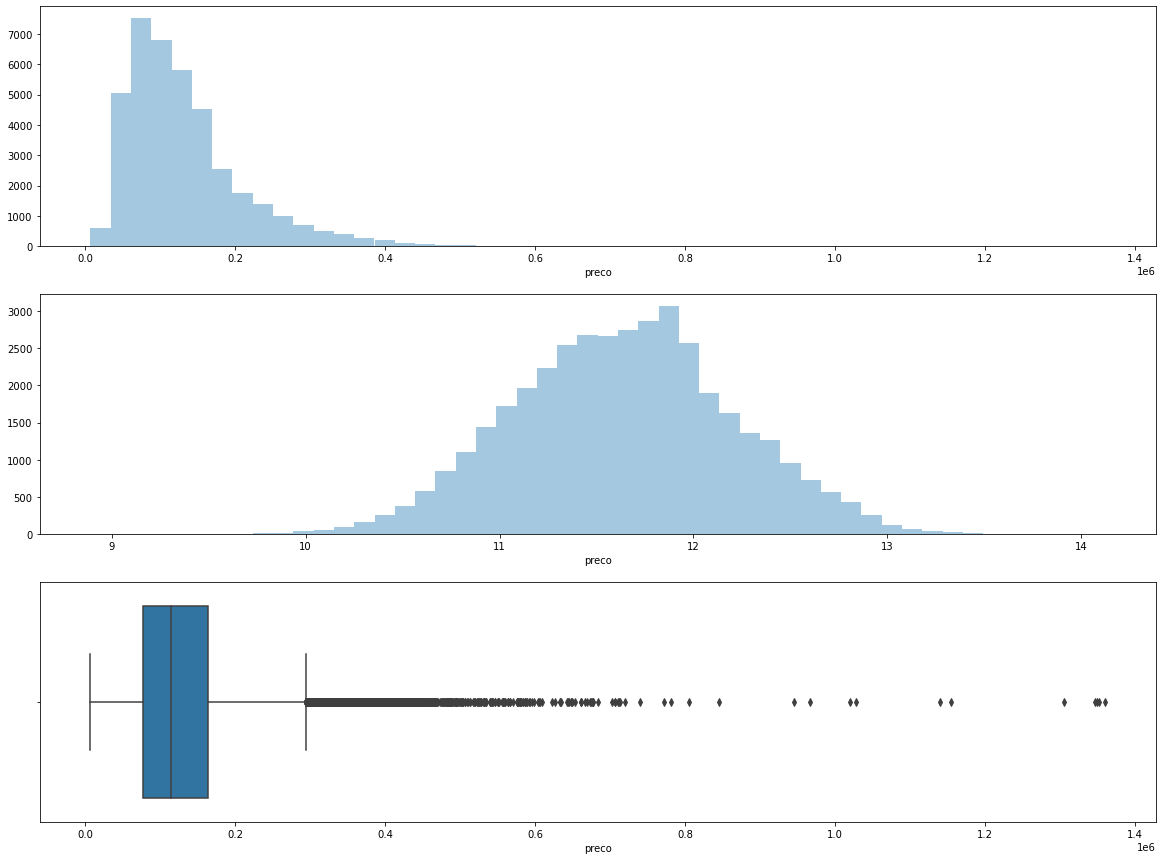

In [27]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
sns.distplot(df4['preco'], kde=False);
# transformação log
plt.subplot(3,1,2)
sns.distplot(np.log(df4['preco']), kde=False);
plt.subplot(3,1,3)
sns.boxplot(df4['preco']);

### 4.1.1. Numerical Variable

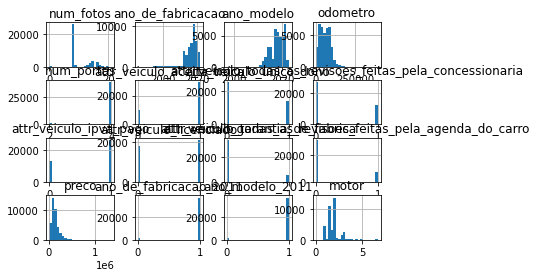

In [28]:
num_attributes = df4.select_dtypes(include='number')
num_attributes.hist(bins=25);

In [29]:
print(df4[df4['ano_de_fabricacao']<2012].shape)
print(df4[df4['ano_modelo']<2012].shape)

(1866, 30)
(332, 30)


In [30]:
df4[df4['ano_de_fabricacao'] == 1988]

,id,num_fotos,marca,modelo,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,...,attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fabrica,attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro,preco,ano_de_fabricacao_2011,ano_modelo_2011,km,motor
430,198942350382439376913441124738612479219,15,FORD,PAMPA,1988,2012,3511,Manual,4,Hatchback,...,0,0,0,0,0,36555.498582,0,0,0_40000,1.8
4797,51936966583809049009169550364057097722,8,PEUGEOT,307,1988,2011,163780,Automática,4,Hatchback,...,1,1,0,0,1,24093.833734,0,0,160000_200000,2.0
20294,73592451487373138990340023028170714089,8,TOYOTA,RAV4,1988,2013,114701,Automática,4,Sedã,...,1,1,1,0,1,59698.612931,0,0,80000_120000,2.4
20569,64369313258166945961672474305820655846,8,VOLKSWAGEN,FUSCA,1988,2011,3548,Manual,4,Perua/SW,...,0,1,0,0,0,28875.849751,0,0,0_40000,1.6


### 4.1.1Categorical Variable

In [31]:
cat_attributes = df4.select_dtypes(exclude='number')
cat_attributes.columns

Index(['id', 'marca', 'modelo', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
       'entrega_delivery', 'troca', 'km'],
      dtype='object')

## 4.2. Analise Bivariada

In [32]:
df4['estado_vendedor'].unique()

array(['São Paulo (SP)', 'Rio Grande do Sul (RS)', 'Minas Gerais (MG)',
       'Paraná (PR)', 'Rio de Janeiro (RJ)', 'Maranhão (MA)',
       'Santa Catarina (SC)', 'Alagoas (AL)', 'Bahia (BA)', 'Goiás (GO)',
       'Rio Grande do Norte (RN)', 'Pernambuco (PE)', 'Mato Grosso (MT)',
       'Pará (PA)', 'Ceará (CE)', 'Amazonas (AM)', 'Espírito Santo (ES)',
       'Rondônia (RO)', 'Paraíba (PB)', 'Tocantins (TO)', 'Acre (AC)',
       'Sergipe (SE)', 'Mato Grosso do Sul (MS)', 'Roraima (RR)',
       'Piauí (PI)'], dtype=object)

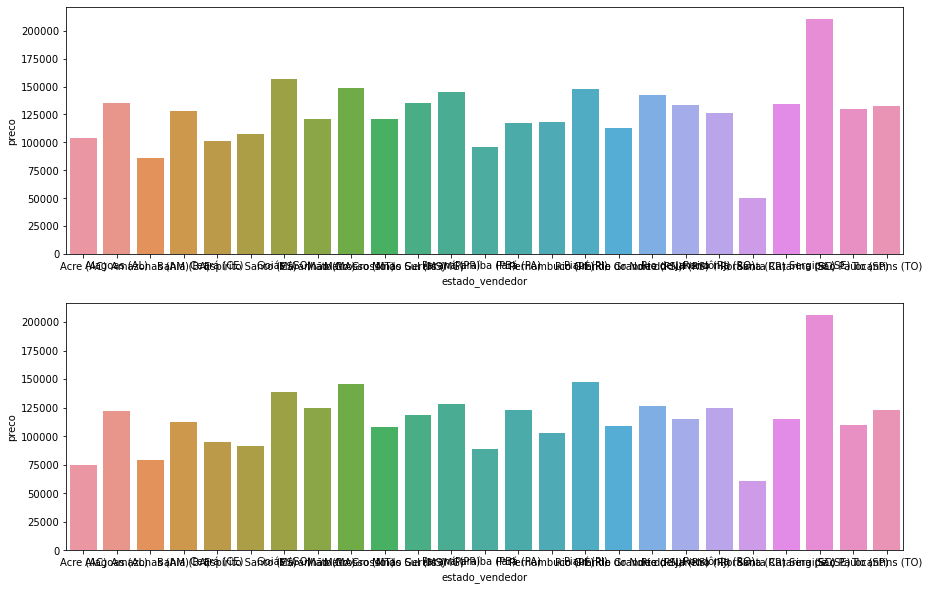

In [33]:
analise_bivariada(df4,'estado_vendedor')

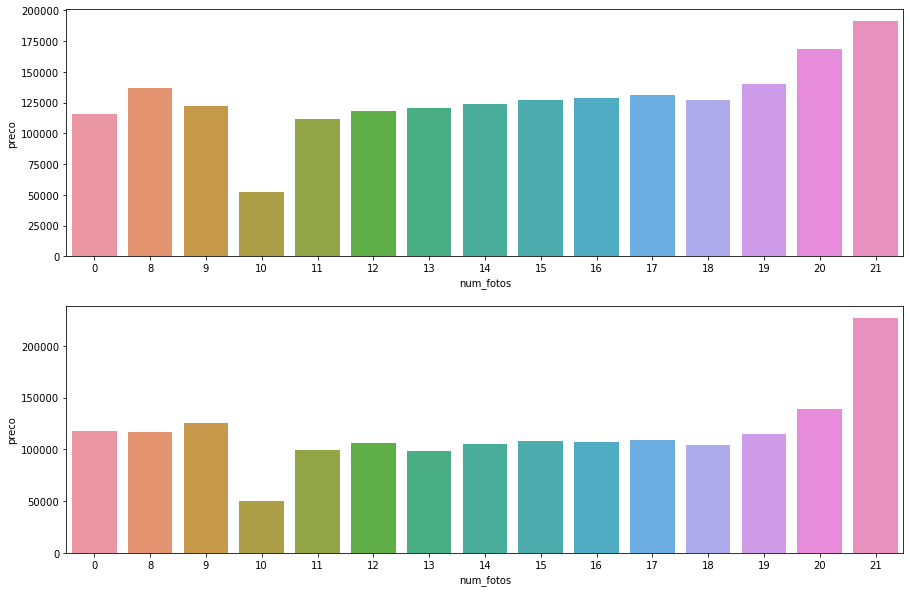

In [34]:
analise_bivariada(df4,'num_fotos')

## 4.3. Analise Multivariada

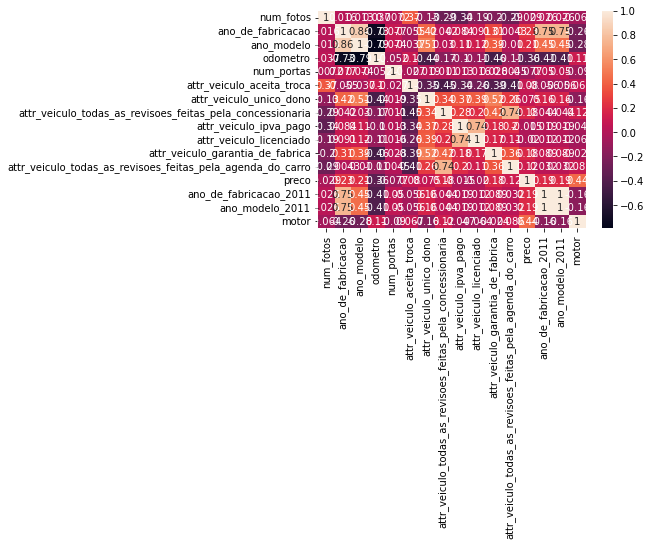

In [35]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [36]:
#plotcor = pycorrcat.corr_matrix(cat_attributes, ['marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
#       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
#       'entrega_delivery', 'troca', 'attr_veiculo_aceita_troca',
#       'attr_veiculo_único_dono',
#       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
#       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
#       'attr_veiculo_garantia_de_fábrica',
#       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'])
#sns.heatmap(plotcor, annot=True);

# 5.0. DATA PREPARATION

In [37]:
df5 = df4.copy()

## 5.1. Encoding

In [38]:
# label encoder
# le = LabelEncoder()
#df5['marca'] = le.fit_transform(df5['marca'])
#df5['cor'] = le.fit_transform(df5['cor'])
#df5['tipo'] = le.fit_transform(df5['tipo'])
# ===================================================

#labelencoding
le = LabelEncoder()
df5['modelo'] = le.fit_transform(df5['modelo'])
#df5['km']=le.fit_transform(df5['km'])
df5['blindado'] = df5['blindado'].apply( lambda x: 1 if x == "S" else 0 )
df5['troca'] = df5['troca'].apply( lambda x: 1 if x == True else 0)
df5['entrega_delivery'] = df5['entrega_delivery'].apply( lambda x: 1 if x == True else 0)

# dummies
df5 = pd.get_dummies( df5, columns=['cambio','tipo_vendedor','tipo_anuncio', 'cor','tipo','km'] )

#frequency encoder
fe_modelo = df5.groupby('modelo').size() / len(df5)
df5.loc[:,'modelo'] = df5['modelo'].map(fe_modelo)
fe_marca = df5.groupby('marca').size() / len(df5)
df5.loc[:,'marca'] = df5['marca'].map(fe_marca)
fe_cidade_vendedor = df5.groupby('cidade_vendedor').size() / len(df5)
df5.loc[:,'cidade_vendedor'] = df5['cidade_vendedor'].map(fe_cidade_vendedor)


df4['estado_vendedor']=df4['estado_vendedor'].apply(lambda x: 'SP' if x=='São Paulo (SP)' else 
                                                        'RS' if x=='Rio Grande do Sul (RS)' else 
                                                        'MG' if x=='Minas Gerais (MG)' else
                                                        'PR' if x=='Paraná (PR)' else
                                                        'RJ' if x=='Rio de Janeiro (RJ)' else
                                                        'MA' if x=='Maranhão (MA)' else
                                                        'SC' if x=='Santa Catarina (SC)' else
                                                        'AL' if x=='Alagoas (AL)' else
                                                        'BA' if x=='Bahia (BA)' else
                                                        'GO' if x=='Goiás (GO)' else
                                                        'RN' if x=='Rio Grande do Norte (RN)' else
                                                        'PE' if x=='Pernambuco (PE)' else
                                                        'MT' if x=='Mato Grosso (MT)' else
                                                        'PA' if x=='Pará (PA)' else
                                                        'CE' if x=='Ceará (CE)' else
                                                        'AM' if x=='Amazonas (AM)' else
                                                        'ES' if x=='Espírito Santo (ES)'else
                                                        'RO' if x=='Rondônia (RO)' else
                                                        'PB' if x=='Paraíba (PB)' else
                                                        'TO' if x=='Tocantins (TO)' else
                                                        'AC' if x=='Acre (AC)'else
                                                        'SE' if x=='Sergipe (SE)' else
                                                        'MS' if x=='Mato Grosso do Sul (MS)' else
                                                        'RR' if x=='Roraima (RR)'else
                                                        'PI' if x=='Piauí (PI)' else 0)

fe_estado_vendedor = df5.groupby('estado_vendedor').size() / len(df5)
df5.loc[:,'estado_vendedor'] = df5['estado_vendedor'].map(fe_estado_vendedor)

## 5.2. Normalização

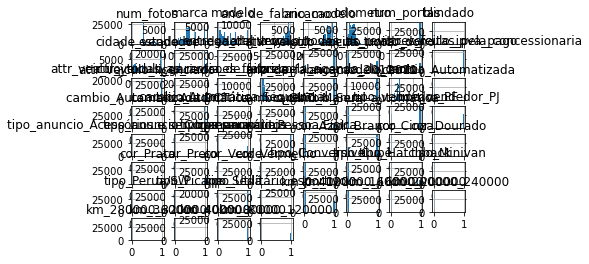

In [39]:
num_attributes = df5.select_dtypes(include='number')
num_attributes.hist(bins=25);

## 5.3. Rescaling

In [40]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['num_fotos'] = mms.fit_transform(df5[['num_fotos']].values)
df5['ano_de_fabricacao'] = rs.fit_transform(df5[['ano_de_fabricacao']].values)
df5['ano_modelo'] = rs.fit_transform(df5[['ano_modelo']].values)
df5['odometro'] = rs.fit_transform(df5[['odometro']].values)

## 5.4. Transformação

# 6.0. FEATURE SELECTION

In [41]:
df6 = df5.copy()

## 6.1. Feature Importancia

In [44]:
# model
#forest = en.ExtraTreesRegressor( n_estimators=250, random_state=0, n_jobs=-1 )

# training
x_train_fselection = df6.drop( ['preco','id'], axis=1 )
y_train_fselection = df6['preco'].values
#forest.fit( x_train_fselection, y_train_fselection )

Feature Ranking:

                                             feature    importance
0                                              motor  1.742625e-01
0                          tipo_Utilitário esportivo  1.586660e-01
0                                         km_0_40000  7.168565e-02
0                                             modelo  6.408736e-02
0                                           odometro  5.141209e-02
0                                              marca  4.874724e-02
0                                        tipo_Picape  4.193550e-02
0                                         ano_modelo  4.150827e-02
0                                  ano_de_fabricacao  3.491937e-02
0                                  cambio_Automática  3.030119e-02
0                                      cambio_Manual  2.845438e-02
0                                    cidade_vendedor  2.730176e-02
0                                         cor_Branco  2.260781e-02
0                                    estado_

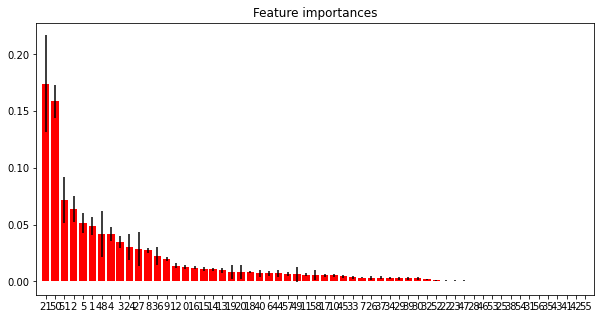

In [ ]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
df = pd.DataFrame()

print( 'Feature Ranking:\n' )
for i, j in zip( x_train_fselection,forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) ) 

# plot the impurity-based feature importances of the forest
plt.figure(figsize=(10,5))
plt.title( 'Feature importances' )
plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_fselection.shape[1]), indices )
plt.xlim( [-1, x_train_fselection.shape[1]] )
plt.show()

## 6.2. Boruta Selection

In [49]:
# training
x_train_fselection = df6.drop( ['preco','id'], axis=1 ).values
y_train_fselection = df6['preco'].values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_fselection, y_train_fselection)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	51
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	51
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	51
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	51
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	52


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	52


In [50]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = df6.drop(['id', 'preco'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected]

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta.columns))


In [53]:
cols_selected_boruta.columns

Index(['marca', 'modelo', 'ano_de_fabricacao', 'ano_modelo', 'odometro',
       'motor', 'tipo_Utilitário esportivo'],
      dtype='object')

## 6.1. Manual Selection

In [56]:
#cols=['preco','motor','tipo_Utilitário esportivo','odometro','modelo','km','tipo_Picape','marca','cambio_Manual','ano_modelo','ano_de_fabricacao','cidade_vendedor','cor_Branco','estado_vendedor','attr_veiculo_aceita_troca','cambio_Automática','num_fotos','attr_veiculo_licenciado','attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria','attr_veiculo_ipva_pago','attr_veiculo_unico_dono','tipo_Cupê','ano_de_fabricacao_2011','tipo_Sedã','ano_modelo_2011','attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro','cor_Preto']
#cols=['preco','motor','tipo_Utilitário esportivo','km_0_40000','modelo','odometro','marca','ano_modelo','tipo_Picape','ano_de_fabricacao','cidade_vendedor','cambio_Automática']

# boruta cols
cols = ['preco', 'marca', 'modelo', 'ano_de_fabricacao', 'ano_modelo', 'odometro', 'motor', 'tipo_Utilitário esportivo']

# 7.0. MACHINE LEARNING MODELLING

In [57]:
df7 = df6[cols].copy()
df7['preco'] = np.log1p(df7['preco'])

In [58]:
X = df7.drop(columns=["preco"])
Y = df7['preco'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 7.1. Linear Regression

In [59]:
# model training
lr = LinearRegression().fit( X_train, y_train )

# prediction
yhat_lr = lr.predict( X_val )

# performance (error)
lr_results = ml_error( 'Linear Regression', np.expm1(y_val) , np.expm1(yhat_lr) )
lr_results

,Model name,MAE,MAPE,RMSE
0,Linear Regression,44174.575606,0.355036,69840.787949


### 7.1.1. Cross Validation

## 7.2. LASSO

### 7.2.1. Cross Validation

## 7.3. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=150, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( X_val )

# performance
rf_results = ml_error( 'Random Forest Regressor',np.expm1(y_val),np.expm1(yhat_rf) )
rf_results

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,28774.928592,0.230011,47678.65835


In [60]:
# model
rf = RandomForestRegressor( n_estimators=150, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( X_val )

# performance
rf_results = ml_error( 'Random Forest Regressor',np.expm1(y_val),np.expm1(yhat_rf) )
rf_results

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,30066.140655,0.241628,49108.409516


### 7.3.1. Cross Validation

## 7.4. Decision Tree Regressor

### 7.4.1. Cross Validation

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( n_estimators=400 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost Regressor', np.expm1(y_val),np.expm1(yhat_xgb) )
model_xgb_results

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,28131.429941,0.22269,46648.49674


In [61]:
# model
model_xgb = xgb.XGBRegressor( n_estimators=400 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost Regressor', np.expm1(y_val),np.expm1(yhat_xgb) )
model_xgb_results

f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,28678.830501,0.226872,47814.97963


### 7.5.1. Cross Validation

## 7.6. LightGBM

In [62]:
# model
model_lgb = lgb.LGBMRegressor( n_estimators=400).fit( X_train, y_train )

# prediction
yhat_lgb = model_lgb.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM Regressor', np.expm1(y_val), np.expm1(yhat_lgb) )
model_lgb_results

,Model name,MAE,MAPE,RMSE
0,LightGBM Regressor,27519.015059,0.21783,46351.174686


### 7.6.1. Cross Validation

In [122]:
from sklearn.model_selection import KFold, cross_val_score

model_lgb = LGBMRegressor(colsample_bytree=0.5403615581709872,
              learning_rate=0.036256176345762295, max_depth=4,
              min_child_samples=45, n_estimators=1215, num_leaves=77,
              random_state=42, subsample=0.14497617002710278, subsample_freq=1)

x = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])
    
kf = KFold(n_splits=5, random_state=42, shuffle=True)    

mae_cv = cross_val_score(model_lgb, x, np.expm1(y), scoring='neg_mean_absolute_error', cv=kf.split(x), n_jobs=-1, verbose=1)*-1

mae_cv
#np.mean(mae_cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


array([30378.83779663, 29600.5072017 , 30637.40599671, 29186.17724612,
       30343.77644401])

In [98]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver

In [128]:
# Search space for hyper parameters
search_space = [Integer( 100, 1500, name = 'n_estimators'), 
                Integer(1, 20, name = 'max_depth'), 
                Real(0.001, 0.1, 'log-uniform', name = 'learning_rate'),
                Integer(2, 128, name = 'num_leaves'),
                Integer(1, 100, name = 'min_child_samples'),
                Real(0.05, 1.0, name = 'subsample'),
                Real(0.15, 1.0, name = 'colsample_bytree')]

# model definition
lgbm_model = LGBMRegressor(n_jobs=-1, random_state=42, subsample_freq=1)

# applying cross-validation into tunning
@use_named_args(search_space)
def model_eval( **params ):
	
    lgbm_model.set_params(**params)
    print(lgbm_model)
    kf = KFold(n_splits=10, random_state=42, shuffle=True)  
    ft_result = cross_val_score(lgbm_model, x, np.expm1(y), scoring='neg_mean_absolute_error', cv=kf.split(x), n_jobs=-1, verbose=1)*-1
    return np.mean(ft_result)

# create checkpoints
checkpoint_callback = CheckpointSaver('lgbm_ft.pkl')

# return results and run bayesian optimize
result = gp_minimize( model_eval, search_space, n_calls = 30, 
                      n_initial_points = 10, verbose=True, n_jobs=-1, 
                      random_state= 42, callback=[checkpoint_callback])
result

Iteration No: 1 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.5403615581709872,
              learning_rate=0.036256176345762295, max_depth=4,
              min_child_samples=45, n_estimators=1215, num_leaves=77,
              random_state=42, subsample=0.14497617002710278, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.6045
Function value obtained: 29991.0977
Current minimum: 29991.0977
Iteration No: 2 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.15066195096486218,
              learning_rate=0.020034427927560734, max_depth=4,
              min_child_samples=72, n_estimators=567, num_leaves=9,
              random_state=42, subsample=0.9416250735649628, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.5450
Function value obtained: 36427.7538
Current minimum: 29991.0977
Iteration No: 3 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.48988182595796725,
              learning_rate=0.01672269700618368, max_depth=13,
              min_child_samples=3, n_estimators=1489, num_leaves=3,
              random_state=42, subsample=0.5485359272454697, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.6748
Function value obtained: 33843.8540
Current minimum: 29991.0977
Iteration No: 4 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.9857462529357701,
              learning_rate=0.0029210748185657135, max_depth=20,
              min_child_samples=62, n_estimators=165, num_leaves=13,
              random_state=42, subsample=0.41333889170380467, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.0420
Function value obtained: 47733.3738
Current minimum: 29991.0977
Iteration No: 5 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.6287949851687085,
              learning_rate=0.022941144328643994, max_depth=17,
              min_child_samples=2, n_estimators=753, num_leaves=59,
              random_state=42, subsample=0.9450916679006104, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.6918
Function value obtained: 27712.4479
Current minimum: 27712.4479
Iteration No: 6 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.8582156749757399,
              learning_rate=0.002895927274708839, max_depth=1,
              min_child_samples=69, n_estimators=640, num_leaves=32,
              random_state=42, subsample=0.62949682489349, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.8533
Function value obtained: 48585.1429
Current minimum: 27712.4479
Iteration No: 7 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.6325452786469928,
              learning_rate=0.0023145798905204883, max_depth=8,
              min_child_samples=43, n_estimators=343, num_leaves=97,
              random_state=42, subsample=0.24754457972477945, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 6.2129
Function value obtained: 41432.3078
Current minimum: 27712.4479
Iteration No: 8 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.42755965348496006,
              learning_rate=0.007934293594590601, max_depth=17,
              min_child_samples=93, n_estimators=144, num_leaves=52,
              random_state=42, subsample=0.7409083960635999, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 1.9849
Function value obtained: 38840.1927
Current minimum: 27712.4479
Iteration No: 9 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.648738490814271,
              learning_rate=0.08362652463906246, max_depth=11,
              min_child_samples=75, n_estimators=899, num_leaves=108,
              random_state=42, subsample=0.5627075257696259, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 15.3106
Function value obtained: 28103.6726
Current minimum: 27712.4479
Iteration No: 10 started. Evaluating function at random point.
LGBMRegressor(colsample_bytree=0.5098912586004143,
              learning_rate=0.0035644979070394624, max_depth=13,
              min_child_samples=17, n_estimators=1451, num_leaves=39,
              random_state=42, subsample=0.06485458640413425, subsample_freq=1)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.3s finished


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 21.8690
Function value obtained: 29990.9489
Current minimum: 27712.4479
Iteration No: 11 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.5404985702457551,
              learning_rate=0.043226704064826184, max_depth=15,
              min_child_samples=1, n_estimators=654, num_leaves=104,
              random_state=42, subsample=0.7786367401083204, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.7s finished


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 9.2823
Function value obtained: 27531.2627
Current minimum: 27531.2627
Iteration No: 12 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.5229318816665964,
              learning_rate=0.02520033832786986, max_depth=20,
              min_child_samples=6, num_leaves=128, random_state=42,
              subsample=0.706952663767402, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 2.3901
Function value obtained: 29505.2272
Current minimum: 27531.2627
Iteration No: 13 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.6459895154788864,
              learning_rate=0.025416172650102455, max_depth=18,
              min_child_samples=2, n_estimators=631, num_leaves=71,
              random_state=42, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 6.8407
Function value obtained: 27728.3307
Current minimum: 27531.2627
Iteration No: 14 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.5039080347726602,
              learning_rate=0.04410721049879651, max_depth=14,
              min_child_samples=1, n_estimators=667, num_leaves=113,
              random_state=42, subsample=0.6583790707429398, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.8s finished


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 11.3947
Function value obtained: 27660.1264
Current minimum: 27531.2627
Iteration No: 15 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.8955105440556923, max_depth=4,
              min_child_samples=68, n_estimators=1051, num_leaves=94,
              random_state=42, subsample=0.831103644878888, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 6.8937
Function value obtained: 28505.1136
Current minimum: 27531.2627
Iteration No: 16 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.20952981801902032, max_depth=20,
              min_child_samples=83, n_estimators=835, num_leaves=128,
              random_state=42, subsample=0.11983453685300151, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.6s finished


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.2056
Function value obtained: 34520.8697
Current minimum: 27531.2627
Iteration No: 17 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.5654336718050068,
              learning_rate=0.04225784559939573, max_depth=12,
              min_child_samples=1, n_estimators=646, num_leaves=102,
              random_state=42, subsample=0.645951288200597, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.0s finished


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 10.6378
Function value obtained: 27624.0316
Current minimum: 27531.2627
Iteration No: 18 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.5527680432974771,
              learning_rate=0.03576190411016418, max_depth=20,
              min_child_samples=3, n_estimators=662, num_leaves=14,
              random_state=42, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 4.1515
Function value obtained: 29015.4690
Current minimum: 27531.2627
Iteration No: 19 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.6414453660957463,
              learning_rate=0.025188004163388202, max_depth=17,
              min_child_samples=1, n_estimators=706, num_leaves=113,
              random_state=42, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.0s finished


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.7041
Function value obtained: 27421.0195
Current minimum: 27421.0195
Iteration No: 20 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.8657369868972951,
              learning_rate=0.07825634801883129, max_depth=9,
              min_child_samples=70, n_estimators=724, num_leaves=91,
              random_state=42, subsample=0.8580626082186013, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.9s finished


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.4714
Function value obtained: 27852.2892
Current minimum: 27421.0195
Iteration No: 21 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.7441859964447753,
              learning_rate=0.038054861125982824, max_depth=8,
              min_child_samples=1, n_estimators=465, num_leaves=128,
              random_state=42, subsample=0.7466051651769517, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.2s finished


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.8837
Function value obtained: 27597.5022
Current minimum: 27421.0195
Iteration No: 22 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.6430422135168571,
              learning_rate=0.04284215609922759, max_depth=14,
              min_child_samples=1, n_estimators=1045, num_leaves=115,
              random_state=42, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.2s finished


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 12.9296
Function value obtained: 27845.0657
Current minimum: 27421.0195
Iteration No: 23 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.9834250625004634,
              learning_rate=0.07236189285264971, max_depth=5,
              min_child_samples=70, n_estimators=984, num_leaves=123,
              random_state=42, subsample=0.6316162171546796, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.0221
Function value obtained: 28513.6168
Current minimum: 27421.0195
Iteration No: 24 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.5051736090977783,
              learning_rate=0.042454372907967095, max_depth=13,
              min_child_samples=1, num_leaves=97, random_state=42,
              subsample=0.4509118933166447, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.5673
Function value obtained: 28809.8582
Current minimum: 27421.0195
Iteration No: 25 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.4744219136251894,
              learning_rate=0.0830462301455459, max_depth=17,
              min_child_samples=76, n_estimators=559, num_leaves=45,
              random_state=42, subsample=0.8234887049413329, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.7s finished


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 6.4084
Function value obtained: 27940.3760
Current minimum: 27421.0195
Iteration No: 26 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.38412638914035035,
              learning_rate=0.04182842175901697, max_depth=7,
              min_child_samples=1, n_estimators=1500, num_leaves=118,
              random_state=42, subsample=0.7337092225115137, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.5s finished


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 24.1176
Function value obtained: 27751.0497
Current minimum: 27421.0195
Iteration No: 27 started. Searching for the next optimal point.
LGBMRegressor(learning_rate=0.04402610566568004, max_depth=8,
              min_child_samples=1, n_estimators=701, num_leaves=23,
              random_state=42, subsample=0.7571784217475648, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 5.8937
Function value obtained: 28240.5993
Current minimum: 27421.0195
Iteration No: 28 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.6344775634230317,
              learning_rate=0.046797281733974565, max_depth=15,
              min_child_samples=1, num_leaves=128, random_state=42,
              subsample=0.7437713821759545, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.4063
Function value obtained: 28186.8660
Current minimum: 27421.0195
Iteration No: 29 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.6908196167714448,
              learning_rate=0.08598606489002585, max_depth=18,
              min_child_samples=74, n_estimators=408, num_leaves=122,
              random_state=42, subsample=0.8236710058672855, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.4335
Function value obtained: 27860.6934
Current minimum: 27421.0195
Iteration No: 30 started. Searching for the next optimal point.
LGBMRegressor(colsample_bytree=0.5278048072625442,
              learning_rate=0.04176758526590465, max_depth=20,
              min_child_samples=1, n_estimators=833, num_leaves=128,
              random_state=42, subsample=0.7504362265932321, subsample_freq=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.2s finished


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 13.8601
Function value obtained: 27686.8644
Current minimum: 27421.0195


          fun: 27421.019510475093
    func_vals: array([29991.09770383, 36427.75381611, 33843.85404113, 47733.37375136,
       27712.44794386, 48585.14294566, 41432.30782907, 38840.1927479 ,
       28103.67255491, 29990.94887304, 27531.26274423, 29505.22723135,
       27728.33066165, 27660.12639768, 28505.11360648, 34520.86967095,
       27624.03160226, 29015.46901363, 27421.01951048, 27852.28920719,
       27597.50224425, 27845.06569956, 28513.61676086, 28809.85824647,
       27940.3760023 , 27751.04973511, 28240.5992822 , 28186.86599428,
       27860.69336518, 27686.86435695])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                      

In [129]:
# check best parameters

result.x

[706, 17, 0.025188004163388202, 113, 1, 1.0, 0.6414453660957463]

# 8.0. COMPARING MODELS PERFORMANCE

## 8.1. Perfomance

## 8.2. Cross Validation Performance

# 9.0. FINE TUNING

In [ ]:
lgb_result_cv = cross_validation(x_training, 5, 'LightGBM', model_lgb, verbose=False)
lgb_result_cv

# 10.0. PRODUCTION

In [64]:
def transform(df00):
    df01=df00.copy()
    df01.columns=['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado']



    df01['num_fotos']=df01['num_fotos'].fillna(0)
    df01['attr_veiculo_aceita_troca'] = df01['attr_veiculo_aceita_troca'].apply(lambda x: 1 if x=='Aceita troca' else 0)
    df01['attr_veiculo_unico_dono'] = df01['attr_veiculo_unico_dono'].apply(lambda x: 1 if x=='Único dono' else 0)
    df01['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'] = df01['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].apply(lambda x: 1 if x=='Todas as revisões feitas pela concessionária' else 0)
    df01['attr_veiculo_ipva_pago'] = df01['attr_veiculo_ipva_pago'].apply(lambda x: 1 if x=='IPVA pago' else 0)
    df01['attr_veiculo_licenciado'] = df01['attr_veiculo_licenciado'].apply(lambda x: 1 if x=='Licenciado' else 0)
    df01['attr_veiculo_garantia_de_fabrica'] = df01['attr_veiculo_garantia_de_fabrica'].apply(lambda x: 1 if x=='Garantia de fábrica' else 0)
    df01['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'] = df01['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].apply(lambda x: 1 if x=='Todas as revisões feitas pela agenda do carro' else 0)




    df01['num_fotos']=df01['num_fotos'].astype('int64')
    df01['ano_modelo']=df01['ano_modelo'].astype('int64')
    df01['odometro']=df01['odometro'].astype('int64')
    df01['attr_veiculo_aceita_troca']=df01['attr_veiculo_aceita_troca'].astype('int64')
    df01['attr_veiculo_unico_dono']=df01['attr_veiculo_unico_dono'].astype('int64')
    df01['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria']=df01['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].astype('int64')
    df01['attr_veiculo_ipva_pago']=df01['attr_veiculo_ipva_pago'].astype('int64')
    df01['attr_veiculo_licenciado']=df01['attr_veiculo_licenciado'].astype('int64')
    df01['attr_veiculo_garantia_de_fabrica']=df01['attr_veiculo_garantia_de_fabrica'].astype('int64')
    df01['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro']=df01['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].astype('int64')
    df01['attr_veiculo_alienado']=df01['attr_veiculo_alienado'].astype(str)


    df02=df01.copy()

    # ano de fabricação
    df02['ano_de_fabricacao_2011']=df02['ano_de_fabricacao'].apply(lambda x: 1 if x>2010 else 0)
    # ano_modelo
    df02['ano_modelo_2011']=df02['ano_de_fabricacao'].apply(lambda x: 1 if x>2010 else 0)
    # kilometragem 100 - 400000
    df02['km']=df02['odometro'].apply(lambda x: '0_40000' if x<=40000 else
                                                '40000_80000'if x<=80000 else
                                                '80000_120000' if x<=120000  else
                                                '120000_160000' if x<=160000  else
                                                '160000_200000' if x<=200000  else
                                                '200000_240000' if x<=240000  else
                                                '240000_280000' if x<=280000  else
                                                '280000_320000' if x<=320000  else
                                                '320000_360000' if x<=360000  else
                                                '360000_400000')
    # motor
    df02['motor_3_chr']=df02['versao'].apply(lambda x: x[0:3])
    df02['motor_num']=df02['motor_3_chr'].apply(lambda x: x[0:1].isnumeric())
    df02['motor_ponto']=df02['motor_3_chr'].apply(lambda x: x[1:2]=='.')
    df02['motor']=df02[['motor_num','motor_ponto','motor_3_chr']].apply(lambda x: x['motor_3_chr'] if (x['motor_num']==True)&(x['motor_ponto']==True) else 0,axis=1)
    df02['motor']=df02['motor'].astype('float64')

    df03=df02.copy()


    df03 = df03.drop( columns=['elegivel_revisao','attr_veiculo_alienado', 'motor_3_chr', 'motor_num', 'motor_ponto','versao'])


    df05=df03.copy()

    #labelencoding
    le = LabelEncoder()
    df05['modelo'] = le.fit_transform(df05['modelo'])
    #df05['km']=le.fit_transform(df05['km'])
    df05['blindado'] = df05['blindado'].apply( lambda x: 1 if x == "S" else 0 )
    df05['troca'] = df05['troca'].apply( lambda x: 1 if x == True else 0)
    df05['entrega_delivery'] = df05['entrega_delivery'].apply( lambda x: 1 if x == True else 0)

    # dummies
    df05 = pd.get_dummies( df05, columns=['cambio','tipo_vendedor','tipo_anuncio', 'cor','tipo','km'] )

    #frequency encoder
    fe_modelo = df05.groupby('modelo').size() / len(df05)
    df05.loc[:,'modelo'] = df05['modelo'].map(fe_modelo)
    fe_marca = df05.groupby('marca').size() / len(df05)
    df05.loc[:,'marca'] = df05['marca'].map(fe_marca)
    fe_cidade_vendedor = df05.groupby('cidade_vendedor').size() / len(df05)
    df05.loc[:,'cidade_vendedor'] = df05['cidade_vendedor'].map(fe_cidade_vendedor)

    df05['estado_vendedor']=df05['estado_vendedor'].apply(lambda x: 'SP' if x=='São Paulo (SP)' else 
                                                            'RS' if x=='Rio Grande do Sul (RS)' else 
                                                            'MG' if x=='Minas Gerais (MG)' else
                                                            'PR' if x=='Paraná (PR)' else
                                                            'RJ' if x=='Rio de Janeiro (RJ)' else
                                                            'MA' if x=='Maranhão (MA)' else
                                                            'SC' if x=='Santa Catarina (SC)' else
                                                            'AL' if x=='Alagoas (AL)' else
                                                            'BA' if x=='Bahia (BA)' else
                                                            'GO' if x=='Goiás (GO)' else
                                                            'RN' if x=='Rio Grande do Norte (RN)' else
                                                            'PE' if x=='Pernambuco (PE)' else
                                                            'MT' if x=='Mato Grosso (MT)' else
                                                            'PA' if x=='Pará (PA)' else
                                                            'CE' if x=='Ceará (CE)' else
                                                            'AM' if x=='Amazonas (AM)' else
                                                            'ES' if x=='Espírito Santo (ES)'else
                                                            'RO' if x=='Rondônia (RO)' else
                                                            'PB' if x=='Paraíba (PB)' else
                                                            'TO' if x=='Tocantins (TO)' else
                                                            'AC' if x=='Acre (AC)'else
                                                            'SE' if x=='Sergipe (SE)' else
                                                            'MS' if x=='Mato Grosso do Sul (MS)' else
                                                            'RR' if x=='Roraima (RR)'else
                                                            'PI' if x=='Piauí (PI)' else 0)

    fe_estado_vendedor = df05.groupby('estado_vendedor').size() / len(df05)
    df05.loc[:,'estado_vendedor'] = df05['estado_vendedor'].map(fe_estado_vendedor)




    rs = RobustScaler()
    mms = MinMaxScaler()

    df05['num_fotos'] = mms.fit_transform(df05[['num_fotos']].values)
    df05['ano_de_fabricacao'] = rs.fit_transform(df05[['ano_de_fabricacao']].values)
    df05['ano_modelo'] = rs.fit_transform(df05[['ano_modelo']].values)
    df05['odometro'] = rs.fit_transform(df05[['odometro']].values)
    
    cols=['marca', 'modelo', 'ano_de_fabricacao', 'ano_modelo', 'odometro', 'motor', 'tipo_Utilitário esportivo']
    return df05[cols]

X_test = transform(df_test)

Full_X_train = pd.concat([X_train, X_val], axis=0)
Full_Y_train = pd.concat([y_train, y_val], axis=0)

# model
model_lgb = lgb.LGBMRegressor(n_estimators=400).fit( Full_X_train, Full_Y_train )

# prediction
preco = model_lgb.predict( X_test )

# performance
df_test['preco'] = np.expm1(preco)
Submission = df_test[['ID','preco']]

In [65]:
Submission.to_csv('Submission_test.csv',index=False)

In [ ]:
Full_X_train = pd.concat([X_train, X_val], axis=0)
Full_Y_train = pd.concat([y_train, y_val], axis=0)

# model
model_lgb = lgb.LGBMRegressor(n_estimators=400).fit( Full_X_train, Full_Y_train )

# prediction
preco = rf.predict( X_test )

# performance
df_test['preco'] = preco
Submission = df_test[['ID','preco']]

In [ ]:
Submission.to_csv( 'Submission_3.csv', index=False )

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3039c7b4-bcc6-4ef2-8633-383a22ac2c90' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>